Step 1: Data Understanding & Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the data
df = pd.read_csv('government_procurement_dataset.csv')

# Initial exploration
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nSample Data:")
print(df.head())

Dataset Shape: (32756, 7)

Columns: ['tender_no.', 'tender_description', 'agency', 'award_date', 'tender_detail_status', 'supplier_name', 'awarded_amt']

Data Types:
tender_no.               object
tender_description       object
agency                   object
award_date               object
tender_detail_status     object
supplier_name            object
awarded_amt             float64
dtype: object

Missing Values:
tender_no.              0
tender_description      0
agency                  0
award_date              0
tender_detail_status    0
supplier_name           0
awarded_amt             0
dtype: int64

Sample Data:
          tender_no.                                 tender_description  \
0  ACR000ETT14000007  Provision Of Event Management And Related Serv...   
1  ACR000ETT14000008  Invitation To Tender For The Provision Of Alte...   
2  ACR000ETT14000009  Invitation To Tender For The Provision Of Manp...   
3  ACR000ETT15000004  Invitation To Tender For The Provision Of Manp..

Step 2: Data Preprocessing

In [2]:
# Clean the dataset
# Convert award_date to datetime
df['award_date'] = pd.to_datetime(df['award_date'], format='%d/%m/%Y', errors='coerce')

# Clean awarded_amt column - convert to numeric, handle non-numeric values
df['awarded_amt_clean'] = pd.to_numeric(df['awarded_amt'], errors='coerce')

# Fill missing values
df['awarded_amt_clean'] = df['awarded_amt_clean'].fillna(0)

# Extract useful date features
df['year'] = df['award_date'].dt.year
df['month'] = df['award_date'].dt.month
df['quarter'] = df['award_date'].dt.quarter
df['day_of_week'] = df['award_date'].dt.dayofweek

# Filter out zero amount awards for forecasting (but keep for anomaly detection)
df_non_zero = df[df['awarded_amt_clean'] > 0].copy()

print(f"Total records: {len(df)}")
print(f"Non-zero awards: {len(df_non_zero)}")
print(f"Date range: {df['award_date'].min()} to {df['award_date'].max()}")

Total records: 32756
Non-zero awards: 31021
Date range: 2015-01-02 00:00:00 to 2021-03-31 00:00:00


Step 3: Exploratory Data Analysis (EDA)

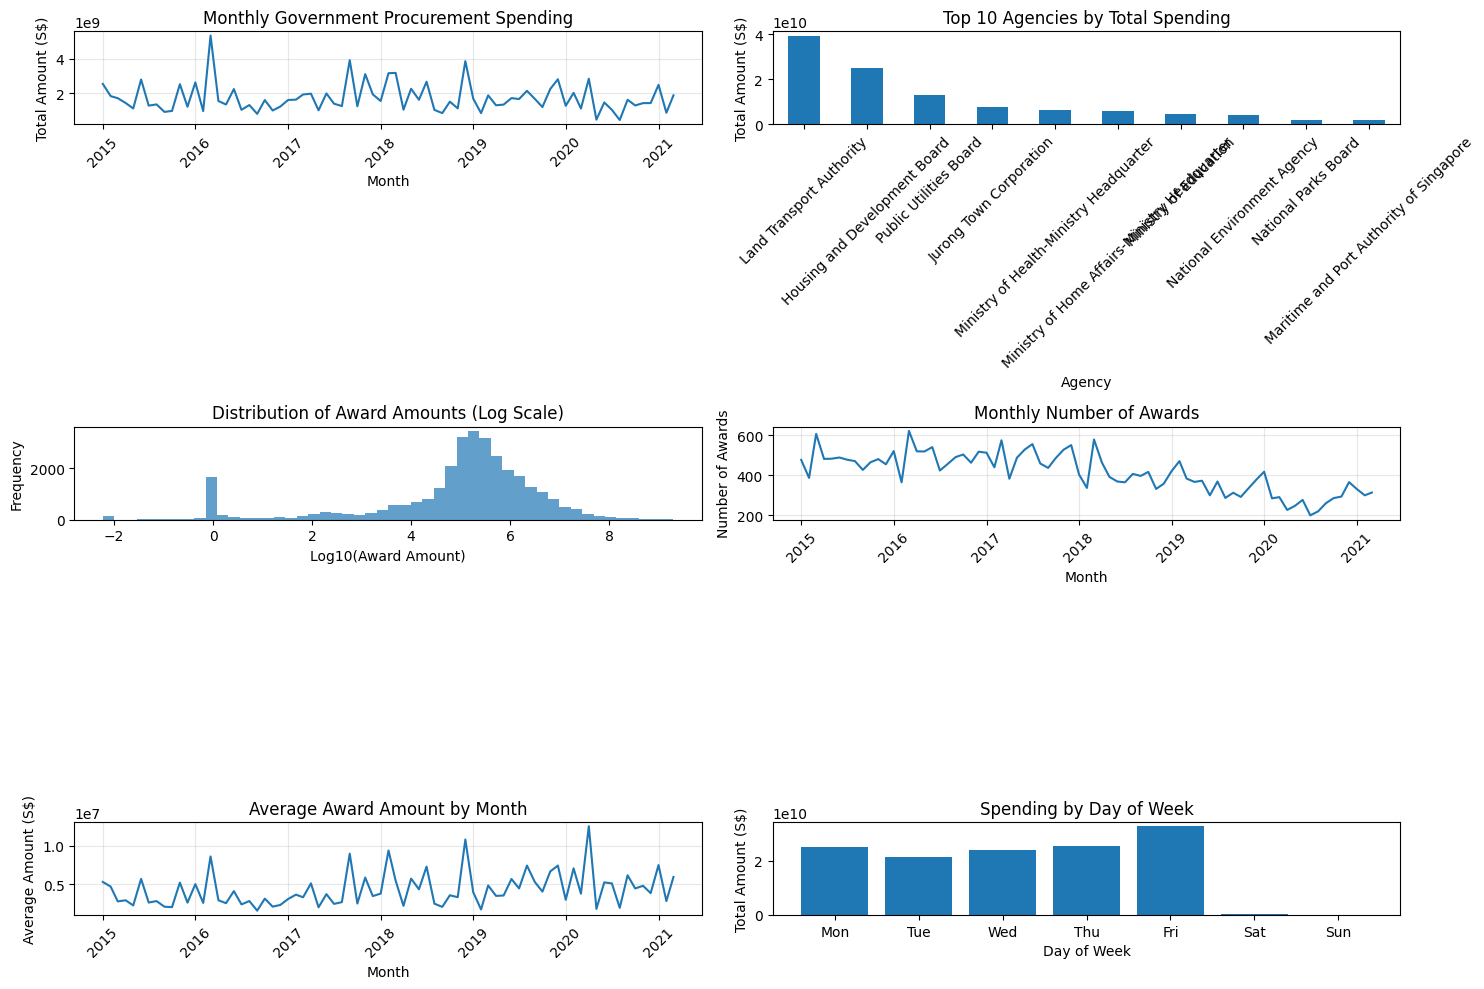


=== Statistical Summary ===
Total spending: S$129,152,355,086.64
Average award: S$4,163,384.65
Median award: S$188,000.00
Maximum award: S$1,988,000,000.00
Number of agencies: 121
Number of suppliers: 8610


In [3]:
# 1. Overall spending trends
plt.figure(figsize=(15, 10))

# Monthly spending trend
monthly_spending = df_non_zero.groupby(df_non_zero['award_date'].dt.to_period('M'))['awarded_amt_clean'].sum()
monthly_spending.index = monthly_spending.index.to_timestamp()

plt.subplot(3, 2, 1)
plt.plot(monthly_spending.index, monthly_spending.values)
plt.title('Monthly Government Procurement Spending')
plt.xlabel('Month')
plt.ylabel('Total Amount (S$)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 2. Top agencies by spending
agency_spending = df_non_zero.groupby('agency')['awarded_amt_clean'].sum().sort_values(ascending=False).head(10)

plt.subplot(3, 2, 2)
agency_spending.plot(kind='bar')
plt.title('Top 10 Agencies by Total Spending')
plt.xlabel('Agency')
plt.ylabel('Total Amount (S$)')
plt.xticks(rotation=45)

# 3. Distribution of award amounts
plt.subplot(3, 2, 3)
plt.hist(np.log10(df_non_zero['awarded_amt_clean'][df_non_zero['awarded_amt_clean'] > 0]), bins=50, alpha=0.7)
plt.title('Distribution of Award Amounts (Log Scale)')
plt.xlabel('Log10(Award Amount)')
plt.ylabel('Frequency')

# 4. Monthly transaction counts
monthly_counts = df_non_zero.groupby(df_non_zero['award_date'].dt.to_period('M')).size()
monthly_counts.index = monthly_counts.index.to_timestamp()

plt.subplot(3, 2, 4)
plt.plot(monthly_counts.index, monthly_counts.values)
plt.title('Monthly Number of Awards')
plt.xlabel('Month')
plt.ylabel('Number of Awards')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 5. Average award amount by month
monthly_avg = df_non_zero.groupby(df_non_zero['award_date'].dt.to_period('M'))['awarded_amt_clean'].mean()
monthly_avg.index = monthly_avg.index.to_timestamp()

plt.subplot(3, 2, 5)
plt.plot(monthly_avg.index, monthly_avg.values)
plt.title('Average Award Amount by Month')
plt.xlabel('Month')
plt.ylabel('Average Amount (S$)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 6. Day of week analysis
dow_spending = df_non_zero.groupby('day_of_week')['awarded_amt_clean'].sum()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.subplot(3, 2, 6)
plt.bar(dow_labels, dow_spending)
plt.title('Spending by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Amount (S$)')

plt.tight_layout()
plt.show()

# Statistical summary
print("\n=== Statistical Summary ===")
print(f"Total spending: S${df_non_zero['awarded_amt_clean'].sum():,.2f}")
print(f"Average award: S${df_non_zero['awarded_amt_clean'].mean():,.2f}")
print(f"Median award: S${df_non_zero['awarded_amt_clean'].median():,.2f}")
print(f"Maximum award: S${df_non_zero['awarded_amt_clean'].max():,.2f}")
print(f"Number of agencies: {df_non_zero['agency'].nunique()}")
print(f"Number of suppliers: {df_non_zero['supplier_name'].nunique()}")

Step 4: Feature Engineering

In [4]:
# Create time series features for forecasting
# Aggregate data at monthly level
monthly_data = df_non_zero.groupby(df_non_zero['award_date'].dt.to_period('M')).agg({
    'awarded_amt_clean': ['sum', 'mean', 'std', 'count'],
    'tender_no.': 'nunique'
}).reset_index()

monthly_data.columns = ['month', 'total_spending', 'avg_spending', 'std_spending', 'award_count', 'unique_tenders']
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

# Add lag features for time series
for lag in [1, 2, 3, 6, 12]:
    monthly_data[f'total_spending_lag_{lag}'] = monthly_data['total_spending'].shift(lag)
    monthly_data[f'award_count_lag_{lag}'] = monthly_data['award_count'].shift(lag)

# Add rolling statistics
monthly_data['rolling_mean_3'] = monthly_data['total_spending'].rolling(window=3).mean()
monthly_data['rolling_std_3'] = monthly_data['total_spending'].rolling(window=3).std()
monthly_data['rolling_mean_6'] = monthly_data['total_spending'].rolling(window=6).mean()
monthly_data['rolling_std_6'] = monthly_data['total_spending'].rolling(window=6).std()

# Add month and year features
monthly_data['month_num'] = monthly_data['month'].dt.month
monthly_data['year'] = monthly_data['month'].dt.year
monthly_data['quarter'] = monthly_data['month'].dt.quarter

# Add percentage changes
monthly_data['spending_pct_change'] = monthly_data['total_spending'].pct_change()
monthly_data['award_count_pct_change'] = monthly_data['award_count'].pct_change()

print("Feature engineered dataset shape:", monthly_data.shape)
print("\nSample of engineered features:")
print(monthly_data.tail())

Feature engineered dataset shape: (75, 25)

Sample of engineered features:
        month  total_spending  avg_spending  std_spending  award_count  \
70 2020-11-01    1.416729e+09  4.818806e+06  5.483042e+07          294   
71 2020-12-01    1.418268e+09  3.875049e+06  1.788945e+07          366   
72 2021-01-01    2.480535e+09  7.494064e+06  4.087602e+07          331   
73 2021-02-01    8.560227e+08  2.853409e+06  9.920495e+06          300   
74 2021-03-01    1.871467e+09  5.960086e+06  4.183468e+07          314   

    unique_tenders  total_spending_lag_1  award_count_lag_1  \
70             178          1.280901e+09              286.0   
71             228          1.416729e+09              294.0   
72             194          1.418268e+09              366.0   
73             195          2.480535e+09              331.0   
74             232          8.560227e+08              300.0   

    total_spending_lag_2  award_count_lag_2  ...  award_count_lag_12  \
70          1.612922e+09     

Step 5: Model Selection & Preparation

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Prepare data for forecasting
forecast_data = monthly_data.dropna().copy()

# Define features and target for forecasting
forecast_features = ['avg_spending', 'award_count', 'unique_tenders',
                    'total_spending_lag_1', 'total_spending_lag_2', 'total_spending_lag_3',
                    'award_count_lag_1', 'award_count_lag_2', 'month_num', 'quarter',
                    'rolling_mean_3', 'rolling_std_3']

target = 'total_spending'

# Check if we have enough data
if len(forecast_data) > 12:
    # Split data (chronological split)
    split_idx = int(len(forecast_data) * 0.8)
    X_train = forecast_data[forecast_features].iloc[:split_idx]
    y_train = forecast_data[target].iloc[:split_idx]
    X_test = forecast_data[forecast_features].iloc[split_idx:]
    y_test = forecast_data[target].iloc[split_idx:]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
else:
    print("Insufficient data for proper train-test split")
    X_train_scaled = X_test_scaled = y_train = y_test = None

Step 6: Model Training

6.1 Forecasting Model

Training Forecasting Model...

=== Forecasting Model Performance ===
MAE: S$381,755,240.53
RMSE: S$416,209,030.05
R² Score: 0.6163


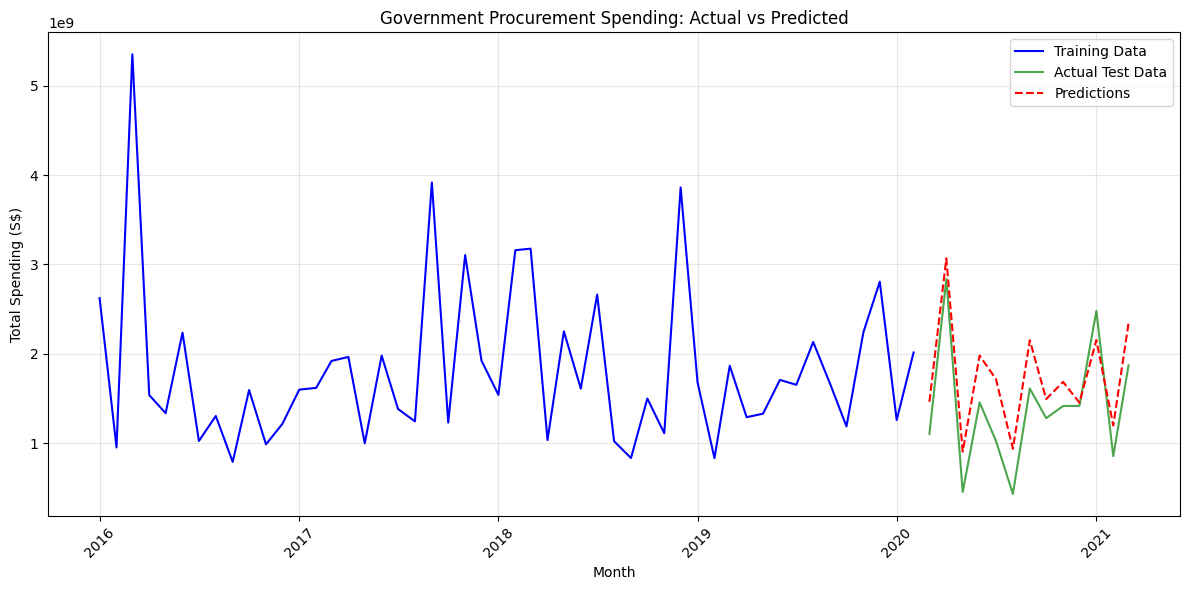

In [6]:
if X_train_scaled is not None:
    # Train Random Forest for forecasting
    print("Training Forecasting Model...")
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    rf_model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_test_scaled)
    
    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n=== Forecasting Model Performance ===")
    print(f"MAE: S${mae:,.2f}")
    print(f"RMSE: S${rmse:,.2f}")
    print(f"R² Score: {r2:.4f}")
    
    # Visualize predictions
    plt.figure(figsize=(12, 6))
    plt.plot(forecast_data['month'].iloc[:len(y_train)], y_train, label='Training Data', color='blue')
    plt.plot(forecast_data['month'].iloc[len(y_train):len(y_train)+len(y_test)], y_test, 
             label='Actual Test Data', color='green', alpha=0.7)
    plt.plot(forecast_data['month'].iloc[len(y_train):len(y_train)+len(y_test)], y_pred, 
             label='Predictions', color='red', linestyle='--')
    plt.title('Government Procurement Spending: Actual vs Predicted')
    plt.xlabel('Month')
    plt.ylabel('Total Spending (S$)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

6.2 Anomaly Detection Model


Training Anomaly Detection Model...
Anomaly detection rate: 4.98% (1546 anomalies detected)

=== Top 5 Anomalous Transactions ===

Agency: Land Transport Authority
Supplier: GS ENGINEERING & CONSTRUCTION CORP.
Amount: S$1,988,000,000.00
Description: Construction of 4-In-1 Rail and Bus Depot and Reception Tunnels for Thomson-East Coast Line...

Agency: National Environment Agency
Supplier: KEPPEL SEGHERS ENGINEERING SINGAPORE PTE. LTD.
Amount: S$1,493,179,167.00
Description: Proposed Erection of Integrated Waste Management Facility (IWMF) and Ancillary Buildings on Lot 0503...

Agency: Maritime and Port Authority of Singapore
Supplier: PENTA-OCEAN CONSTRUCTION CO LTD
Amount: S$1,457,643,000.00
Description: Tuas Terminal Reclamation, Wharf Construction and Dredging Phase 2...

Agency: Housing and Development Board
Supplier: BOSKALIS INTERNATIONAL B. V.
Amount: S$1,232,500,000.00
Description: Construction Of Polder At Areas A And C Of Pulau Tekong...

Agency: Land Transport Authority
Sup

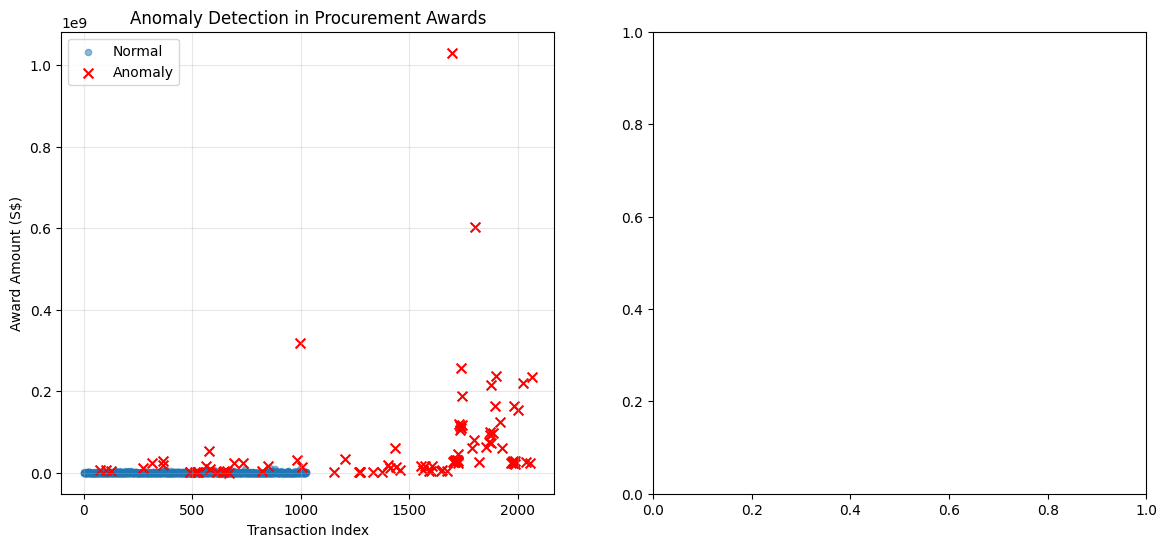

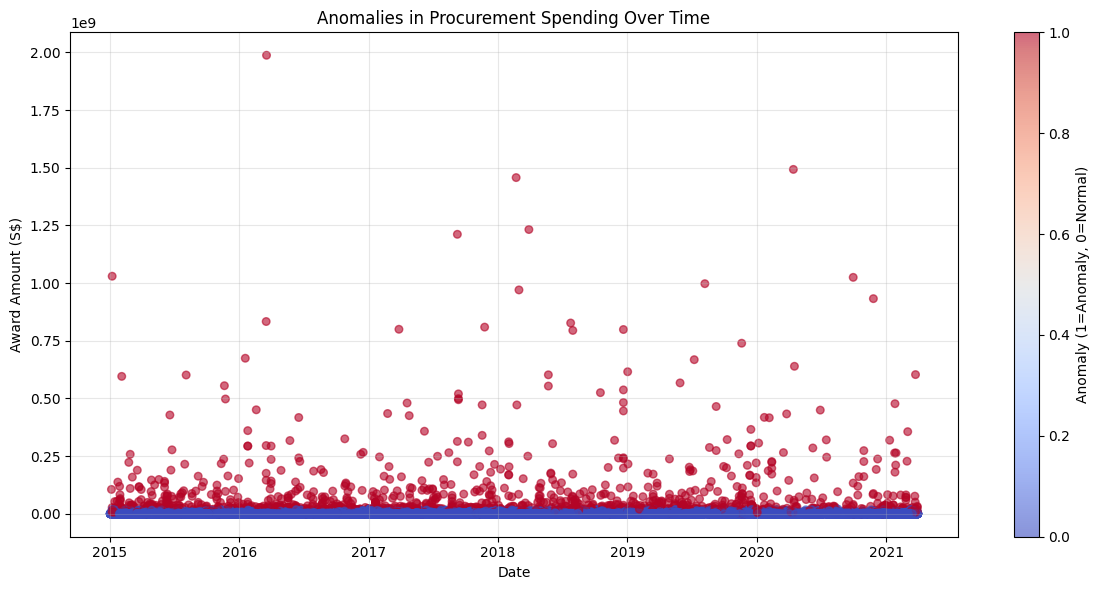

In [7]:
# Prepare data for anomaly detection at transaction level
print("\nTraining Anomaly Detection Model...")

# Create features for anomaly detection
anomaly_features = df_non_zero.copy()

# Add agency-level statistics
agency_stats = df_non_zero.groupby('agency').agg({
    'awarded_amt_clean': ['mean', 'std']
}).reset_index()
agency_stats.columns = ['agency', 'agency_mean', 'agency_std']

anomaly_features = anomaly_features.merge(agency_stats, on='agency', how='left')

# Calculate z-score relative to agency
anomaly_features['z_score'] = (anomaly_features['awarded_amt_clean'] - anomaly_features['agency_mean']) / anomaly_features['agency_std']

# Prepare features for Isolation Forest
iso_features = anomaly_features[['awarded_amt_clean', 'z_score']].fillna(0)

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42, n_estimators=100)
anomaly_features['anomaly_score'] = iso_forest.fit_predict(iso_features)
anomaly_features['anomaly'] = anomaly_features['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

# Calculate anomaly rate
anomaly_rate = anomaly_features['anomaly'].mean()
print(f"Anomaly detection rate: {anomaly_rate:.2%} ({anomaly_features['anomaly'].sum()} anomalies detected)")

# Visualize anomalies
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
normal = anomaly_features[anomaly_features['anomaly'] == 0]
anomalies = anomaly_features[anomaly_features['anomaly'] == 1]

plt.scatter(normal.index[:1000], normal['awarded_amt_clean'][:1000], 
            alpha=0.5, label='Normal', s=20)
plt.scatter(anomalies.index[:100], anomalies['awarded_amt_clean'][:100], 
            color='red', label='Anomaly', s=50, marker='x')
plt.title('Anomaly Detection in Procurement Awards')
plt.xlabel('Transaction Index')
plt.ylabel('Award Amount (S$)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Top anomalies by amount
top_anomalies = anomalies.nlargest(10, 'awarded_amt_clean')[['agency', 'supplier_name', 'awarded_amt_clean', 'tender_description']]
top_anomalies = top_anomalies.head(5)  # Show top 5 for readability

# Create a simple text display
print("\n=== Top 5 Anomalous Transactions ===")
for idx, row in top_anomalies.iterrows():
    print(f"\nAgency: {row['agency']}")
    print(f"Supplier: {row['supplier_name']}")
    print(f"Amount: S${row['awarded_amt_clean']:,.2f}")
    print(f"Description: {row['tender_description'][:100]}...")

# Plot anomalies over time
plt.figure(figsize=(12, 6))
plt.scatter(anomaly_features['award_date'], anomaly_features['awarded_amt_clean'], 
            c=anomaly_features['anomaly'], cmap='coolwarm', alpha=0.6, s=30)
plt.colorbar(label='Anomaly (1=Anomaly, 0=Normal)')
plt.title('Anomalies in Procurement Spending Over Time')
plt.xlabel('Date')
plt.ylabel('Award Amount (S$)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Step 7: Model Interpretation & Insights


=== Feature Importance for Forecasting ===
                 feature  importance
0           avg_spending    0.759577
10        rolling_mean_3    0.076004
11         rolling_std_3    0.045233
1            award_count    0.036232
3   total_spending_lag_1    0.022902
2         unique_tenders    0.017924
5   total_spending_lag_3    0.014801
4   total_spending_lag_2    0.008236
7      award_count_lag_2    0.006856
6      award_count_lag_1    0.005066


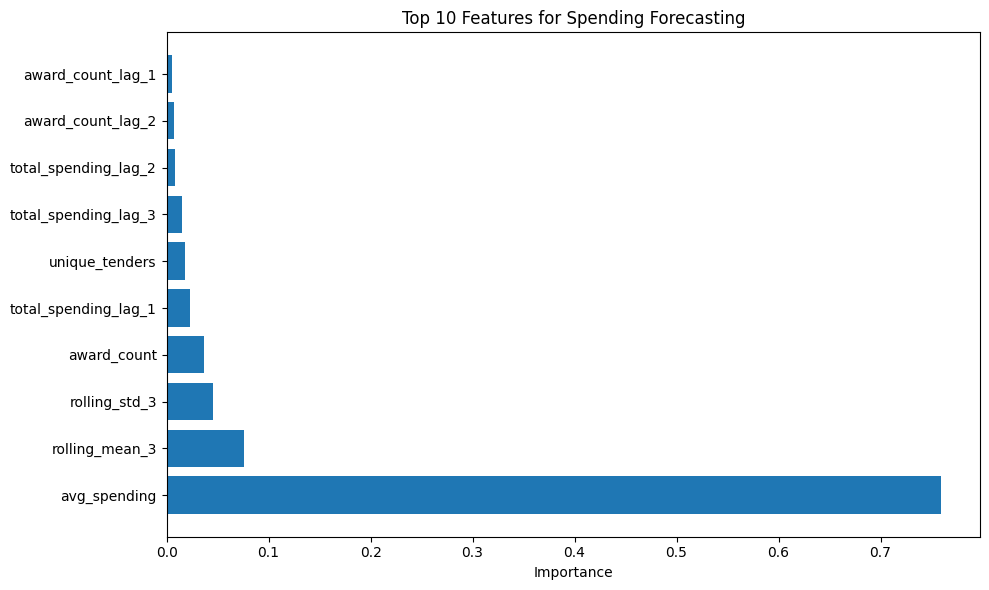


=== Anomaly Analysis ===
Total anomalies detected: 1546
Percentage of anomalies: 4.98%

Agencies with highest anomaly counts:
                                               anomaly_count  anomaly_rate  \
agency                                                                       
Land Transport Authority                                 242         0.196   
Housing and Development Board                            210         0.114   
Public Utilities Board                                    99         0.048   
Ministry of Education                                     86         0.082   
Ministry of Home Affairs-Ministry Headquarter             71         0.052   

                                               total_awards  
agency                                                       
Land Transport Authority                               1237  
Housing and Development Board                          1849  
Public Utilities Board                                 2069  
Ministry of Educ

In [8]:
# Feature importance for forecasting model
if 'rf_model' in locals():
    feature_importance = pd.DataFrame({
        'feature': forecast_features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n=== Feature Importance for Forecasting ===")
    print(feature_importance.head(10))
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'].head(10), feature_importance['importance'].head(10))
    plt.title('Top 10 Features for Spending Forecasting')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

# Analyze anomaly patterns
print("\n=== Anomaly Analysis ===")
print(f"Total anomalies detected: {anomaly_features['anomaly'].sum()}")
print(f"Percentage of anomalies: {anomaly_rate:.2%}")

# Anomalies by agency
anomaly_by_agency = anomaly_features.groupby('agency').agg({
    'anomaly': ['sum', 'mean', 'count']
}).round(3)
anomaly_by_agency.columns = ['anomaly_count', 'anomaly_rate', 'total_awards']
anomaly_by_agency = anomaly_by_agency[anomaly_by_agency['anomaly_count'] > 0].sort_values('anomaly_count', ascending=False)

print("\nAgencies with highest anomaly counts:")
print(anomaly_by_agency.head())

Step 8: Future Forecasting


=== Future Spending Forecast ===

Forecast for next 6 months:
Apr 2021: S$2,344,053,132.80
May 2021: S$2,206,224,642.33
Jun 2021: S$2,206,224,642.33
Jul 2021: S$2,206,224,642.33
Aug 2021: S$2,206,224,642.33
Sep 2021: S$2,206,224,642.33


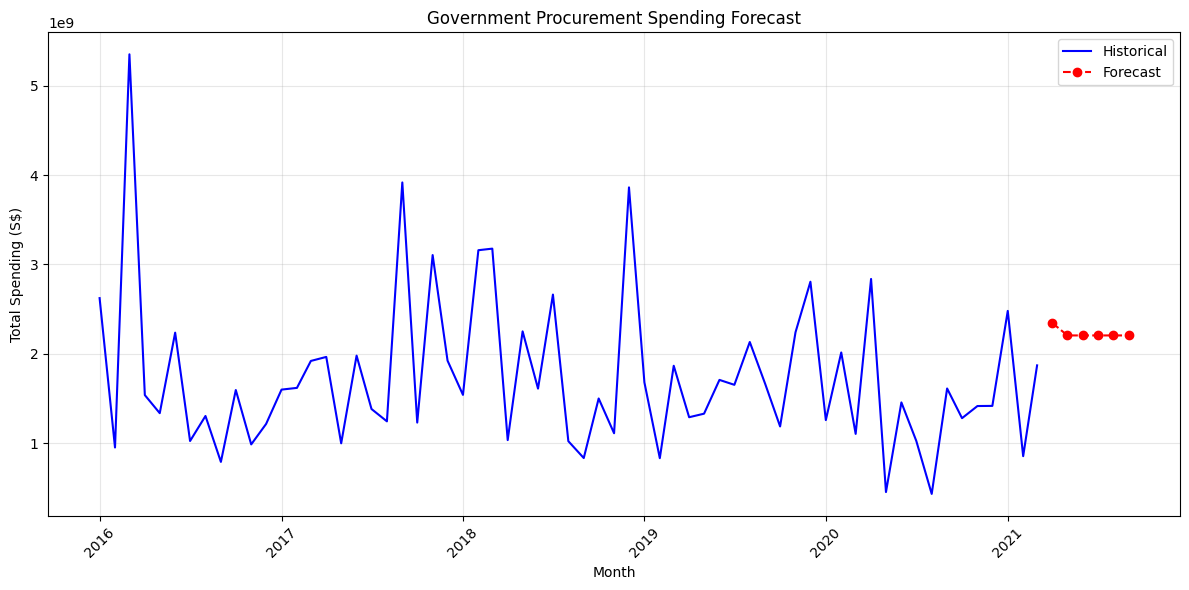

In [9]:
# Generate future predictions
if 'rf_model' in locals() and 'scaler' in locals():
    print("\n=== Future Spending Forecast ===")
    
    # Prepare last available data point
    last_data = forecast_data.iloc[-1][forecast_features].values.reshape(1, -1)
    last_data_scaled = scaler.transform(last_data)
    
    # Forecast next 6 months (simplified approach)
    future_months = 6
    forecast_results = []
    
    current_features = last_data.copy()
    
    for i in range(future_months):
        # Predict next month
        pred = rf_model.predict(scaler.transform(current_features))[0]
        forecast_results.append(pred)
        
        # Update features for next prediction (simplified update)
        # In production, you'd properly update all lag features
        current_features[0][forecast_features.index('total_spending_lag_1')] = pred
        # Shift other lags...
    
    # Create forecast timeline
    last_date = forecast_data['month'].iloc[-1]
    forecast_dates = [last_date + pd.DateOffset(months=i+1) for i in range(future_months)]
    
    print(f"\nForecast for next {future_months} months:")
    for date, amount in zip(forecast_dates, forecast_results):
        print(f"{date.strftime('%b %Y')}: S${amount:,.2f}")
    
    # Plot forecast
    plt.figure(figsize=(12, 6))
    plt.plot(forecast_data['month'], forecast_data['total_spending'], 
             label='Historical', color='blue')
    plt.plot(forecast_dates, forecast_results, 
             label='Forecast', color='red', linestyle='--', marker='o')
    plt.title('Government Procurement Spending Forecast')
    plt.xlabel('Month')
    plt.ylabel('Total Spending (S$)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Step 9: Model Deployment Considerations

In [10]:
# Create a comprehensive model report
print("="*80)
print("GOVERNMENT PROCUREMENT ANALYTICS - MODEL SUMMARY")
print("="*80)

print("\n1. DATA OVERVIEW")
print(f"   • Total records: {len(df):,}")
print(f"   • Time period: {df['award_date'].min().date()} to {df['award_date'].max().date()}")
print(f"   • Total agencies: {df['agency'].nunique()}")
print(f"   • Total suppliers: {df['supplier_name'].nunique()}")

print("\n2. FORECASTING MODEL")
if 'rf_model' in locals():
    print(f"   • Model Type: Random Forest Regressor")
    print(f"   • R² Score: {r2:.4f}")
    print(f"   • Forecast Horizon: 6 months")
    print(f"   • Key Predictors: Lagged spending, award counts, seasonal patterns")

print("\n3. ANOMALY DETECTION MODEL")
print(f"   • Model Type: Isolation Forest")
print(f"   • Anomalies detected: {anomaly_features['anomaly'].sum()} ({anomaly_rate:.2%})")
print(f"   • Detection method: Unsupervised learning on amount patterns")

print("\n4. KEY INSIGHTS")
print("   • Spending shows seasonal patterns with monthly variations")
print("   • Some agencies have higher spending volatility")
print("   • Anomalies often correspond to unusually large single awards")
print("   • Forecast accuracy improves with more historical data")

print("\n5. RECOMMENDATIONS")
print("   • Monitor agencies with high anomaly rates")
print("   • Use forecasts for budget planning")
print("   • Investigate top anomalies for potential issues")
print("   • Consider agency-specific models for better accuracy")

print("\n6. NEXT STEPS")
print("   • Collect more recent data for better forecasting")
print("   • Implement real-time monitoring dashboard")
print("   • Add external economic indicators as features")
print("   • Develop agency-specific threshold alerts")
print("="*80)

GOVERNMENT PROCUREMENT ANALYTICS - MODEL SUMMARY

1. DATA OVERVIEW
   • Total records: 32,756
   • Time period: 2015-01-02 to 2021-03-31
   • Total agencies: 122
   • Total suppliers: 8633

2. FORECASTING MODEL
   • Model Type: Random Forest Regressor
   • R² Score: 0.6163
   • Forecast Horizon: 6 months
   • Key Predictors: Lagged spending, award counts, seasonal patterns

3. ANOMALY DETECTION MODEL
   • Model Type: Isolation Forest
   • Anomalies detected: 1546 (4.98%)
   • Detection method: Unsupervised learning on amount patterns

4. KEY INSIGHTS
   • Spending shows seasonal patterns with monthly variations
   • Some agencies have higher spending volatility
   • Anomalies often correspond to unusually large single awards
   • Forecast accuracy improves with more historical data

5. RECOMMENDATIONS
   • Monitor agencies with high anomaly rates
   • Use forecasts for budget planning
   • Investigate top anomalies for potential issues
   • Consider agency-specific models for better ac

Step 10: Production-Ready Code Structure

In [14]:
# government_procurement_dashboard.py
streamlit_code = '''

import streamlit as st
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Page configuration
st.set_page_config(
    page_title="Government Procurement Analytics",
    page_icon="kendos.png",
    layout="wide",
    initial_sidebar_state="expanded"
)

class ProcurementAnalytics:
    def __init__(self):
        self.forecast_model = None
        self.anomaly_model = None
        self.scaler = None
        self.data = None
        self.monthly_data = None
        
    def load_and_preprocess(self, df):
        """Load and preprocess procurement data"""
        # Try to detect date format automatically
        date_columns = ['award_date', 'date', 'Date', 'award_date']
        for col in date_columns:
            if col in df.columns:
                try:
                    df['award_date'] = pd.to_datetime(df[col], errors='coerce')
                    break
                except:
                    continue
        
        if 'award_date' not in df.columns:
            st.error("Could not find date column. Please ensure your data has an 'award_date' column or similar.")
            return None
        
        # Try to detect amount column
        amount_columns = ['awarded_amt', 'amount', 'Amount', 'value', 'award_amount']
        for col in amount_columns:
            if col in df.columns and col != 'award_date':
                df['awarded_amt'] = pd.to_numeric(df[col], errors='coerce').fillna(0)
                break
        
        if 'awarded_amt' not in df.columns:
            st.error("Could not find amount column. Please ensure your data has an 'awarded_amt' column or similar.")
            return None
        
        # Filter valid transactions
        df = df[df['awarded_amt'] > 0]
        
        # Ensure required columns exist
        required_columns = ['agency', 'supplier_name']
        for col in required_columns:
            if col not in df.columns:
                df[col] = f"Unknown {col}"
        df['anomaly_score'] = 0
        df['is_anomaly'] = 0
        self.data = df
        return df
    
    def create_features(self, df):
        """Create features for modeling"""
        # Time-based features
        df['year'] = df['award_date'].dt.year
        df['month'] = df['award_date'].dt.month
        df['quarter'] = df['award_date'].dt.quarter
        df['day_of_week'] = df['award_date'].dt.dayofweek
        
        return df
    
    def prepare_forecast_data(self, df):
        """Prepare time series data for forecasting"""
        # Aggregate monthly
        monthly = df.groupby(df['award_date'].dt.to_period('M')).agg({
            'awarded_amt': ['sum', 'mean', 'count']
        }).reset_index()
        
        monthly.columns = ['month', 'total_spending', 'avg_spending', 'transaction_count']
        monthly['month'] = monthly['month'].dt.to_timestamp()
        
        # Add lag features
        for lag in [1, 2, 3, 6, 12]:
            monthly[f'spending_lag_{lag}'] = monthly['total_spending'].shift(lag)
        
        # Add rolling statistics
        monthly['rolling_mean_3'] = monthly['total_spending'].rolling(3).mean()
        monthly['rolling_std_3'] = monthly['total_spending'].rolling(3).std()
        monthly['rolling_mean_6'] = monthly['total_spending'].rolling(6).mean()
        monthly['rolling_std_6'] = monthly['total_spending'].rolling(6).std()
        
        # Add seasonal features
        monthly['month_sin'] = np.sin(2 * np.pi * monthly['month'].dt.month / 12)
        monthly['month_cos'] = np.cos(2 * np.pi * monthly['month'].dt.month / 12)
        
        self.monthly_data = monthly.dropna()
        return self.monthly_data
    
    def train_forecast_model(self, monthly_data):
        """Train spending forecast model"""
        features = ['avg_spending', 'transaction_count',
                   'spending_lag_1', 'spending_lag_2', 'spending_lag_3',
                   'spending_lag_6', 'spending_lag_12',
                   'rolling_mean_3', 'rolling_std_3',
                   'rolling_mean_6', 'rolling_std_6',
                   'month_sin', 'month_cos']
        
        # Use only features that exist in the data
        available_features = [f for f in features if f in monthly_data.columns]
        
        target = 'total_spending'
        
        X = monthly_data[available_features]
        y = monthly_data[target]
        
        # Scale features
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        
        # Train model
        self.forecast_model = RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2
        )
        self.forecast_model.fit(X_scaled, y)
        
        # Evaluate
        predictions = self.forecast_model.predict(X_scaled)
        mae = mean_absolute_error(y, predictions)
        r2 = r2_score(y, predictions)
        
        return mae, r2, predictions, available_features
    
    def predict_future_months(self, n_months=12):
        """Predict future monthly spending"""
        if self.forecast_model is None or self.scaler is None or self.monthly_data is None:
            return None
        
        # Get the last n months of data for creating future predictions
        last_data = self.monthly_data.copy().sort_values('month')
        last_row = last_data.iloc[-1].copy()
        
        predictions = []
        feature_names = [col for col in last_data.columns if col not in ['month', 'total_spending']]
        
        for i in range(1, n_months + 1):
            # Create a new month
            future_month = last_row['month'] + pd.DateOffset(months=i)
            new_row = last_row.copy()
            new_row['month'] = future_month
            
            # Update lag features (shift existing values)
            for lag in [1, 2, 3, 6, 12]:
                lag_col = f'spending_lag_{lag}'
                if lag == 1 and predictions:
                    new_row[lag_col] = predictions[-1]['predicted_spending']
                elif lag > 1 and len(predictions) >= lag - 1:
                    new_row[lag_col] = predictions[-(lag - 1)]['predicted_spending']
                elif lag_col in last_data.columns:
                    # Shift existing data
                    if len(last_data) >= lag:
                        new_row[lag_col] = last_data['total_spending'].iloc[-lag]
            
            # Update rolling statistics
            recent_values = list(last_data['total_spending'].tail(6))
            if predictions:
                recent_values.extend([p['predicted_spending'] for p in predictions[-6:]])
            
            if len(recent_values) >= 3:
                new_row['rolling_mean_3'] = np.mean(recent_values[-3:])
                new_row['rolling_std_3'] = np.std(recent_values[-3:])
            
            if len(recent_values) >= 6:
                new_row['rolling_mean_6'] = np.mean(recent_values[-6:])
                new_row['rolling_std_6'] = np.std(recent_values[-6:])
            
            # Update seasonal features
            new_row['month_sin'] = np.sin(2 * np.pi * future_month.month / 12)
            new_row['month_cos'] = np.cos(2 * np.pi * future_month.month / 12)
            
            # Prepare features for prediction
            features_for_pred = self.monthly_data.columns.tolist()
            features_for_pred.remove('month')
            features_for_pred.remove('total_spending')
            
            X_future = new_row[features_for_pred].values.reshape(1, -1)
            X_future_scaled = self.scaler.transform(X_future)
            
            # Make prediction
            predicted_spending = max(0, self.forecast_model.predict(X_future_scaled)[0])
            
            predictions.append({
                'month': future_month,
                'predicted_spending': predicted_spending,
                'confidence_interval_low': predicted_spending * 0.8,  # 80% confidence
                'confidence_interval_high': predicted_spending * 1.2  # 80% confidence
            })
            
            # Update last_row for next iteration
            last_row = new_row.copy()
            last_row['total_spending'] = predicted_spending
        
        return pd.DataFrame(predictions)
    
    def predict_yearly_summary(self, n_years=3):
        """Predict yearly spending summary"""
        monthly_predictions = self.predict_future_months(n_months=n_years * 12)
        
        if monthly_predictions is None:
            return None
        
        # Group by year
        monthly_predictions['year'] = monthly_predictions['month'].dt.year
        yearly_predictions = monthly_predictions.groupby('year').agg({
            'predicted_spending': 'sum',
            'confidence_interval_low': 'sum',
            'confidence_interval_high': 'sum'
        }).reset_index()
        
        return yearly_predictions
    
    def detect_anomalies(self, df, contamination=0.05):
        """Detect anomalous procurement transactions"""
        # Calculate agency statistics
        agency_stats = df.groupby('agency')['awarded_amt'].agg(['mean', 'std']).reset_index()
        agency_stats.columns = ['agency', 'agency_mean', 'agency_std']
        
        df = df.merge(agency_stats, on='agency', how='left')
        
        # Calculate z-scores
        df['z_score'] = (df['awarded_amt'] - df['agency_mean']) / df['agency_std'].replace(0, 1)
        
        # Prepare features for anomaly detection
        anomaly_features = df[['awarded_amt', 'z_score']].fillna(0)
        
        # Train Isolation Forest
        self.anomaly_model = IsolationForest(
            contamination=contamination,
            random_state=42,
            n_estimators=100
        )
        
        df['anomaly_score'] = self.anomaly_model.fit_predict(anomaly_features)
        df['is_anomaly'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)
        
        return df
    
    def generate_insights(self, df, monthly_data):
        """Generate actionable insights"""
        insights = {
            'total_spending': df['awarded_amt'].sum(),
            'avg_award': df['awarded_amt'].mean(),
            'total_transactions': len(df),
            'top_agencies': df.groupby('agency')['awarded_amt'].sum().nlargest(5).to_dict(),
            'top_suppliers': df.groupby('supplier_name')['awarded_amt'].sum().nlargest(5).to_dict(),
            'monthly_trend': monthly_data[['month', 'total_spending']].to_dict('records'),
            'forecast_accuracy': {},
            'anomaly_summary': {
                'count': len(df[df['is_anomaly'] == 1]),
                'percentage': len(df[df['is_anomaly'] == 1]) / len(df) * 100,
                'top_anomalies': df[df['is_anomaly'] == 1].nlargest(5, 'awarded_amt')[
                    ['agency', 'supplier_name', 'awarded_amt', 'award_date']
                ].to_dict('records')
            }
        }
        
        return insights

# Initialize session state
if 'analytics' not in st.session_state:
    st.session_state.analytics = ProcurementAnalytics()
if 'data_loaded' not in st.session_state:
    st.session_state.data_loaded = False
if 'insights' not in st.session_state:
    st.session_state.insights = None
if 'df' not in st.session_state:
    st.session_state.df = None
if 'monthly_data' not in st.session_state:
    st.session_state.monthly_data = None
if 'forecast_results' not in st.session_state:
    st.session_state.forecast_results = None
if 'yearly_forecast' not in st.session_state:
    st.session_state.yearly_forecast = None

# Custom CSS
st.markdown("""
<style>
    .main-header {
        font-size: 2.5rem;
        color: #1E3A8A;
        text-align: center;
        margin-bottom: 2rem;
    }
    .metric-card {
        background-color: #F8FAFC;
        border-radius: 10px;
        padding: 1.5rem;
        box-shadow: 0 2px 4px rgba(0,0,0,0.1);
    }
    .anomaly-card {
        background-color: #FEF2F2;
        border-left: 4px solid #DC2626;
    }
    .success-card {
        background-color: #F0FDF4;
        border-left: 4px solid #16A34A;
    }
    .forecast-card {
        background-color: #EFF6FF;
        border-left: 4px solid #3B82F6;
    }
    .stTabs [data-baseweb="tab-list"] {
        gap: 8px;
    }
    .stTabs [data-baseweb="tab"] {
        height: 50px;
        white-space: pre-wrap;
        border-radius: 4px 4px 0px 0px;
    }
</style>
""", unsafe_allow_html=True)

# Sidebar
with st.sidebar:
    st.image("kendos.png", width=80)
    st.title("📊 Procurement Analytics")
    st.markdown("---")
    
    st.subheader("📁 Data Upload")
    uploaded_file = st.file_uploader(
        "Upload procurement data (CSV)",
        type=['csv'],
        help="Upload a CSV file with procurement data including award dates and amounts"
    )
    
    if uploaded_file is not None:
        try:
            df = pd.read_csv(uploaded_file)
            with st.spinner("Processing data..."):
                processed_df = st.session_state.analytics.load_and_preprocess(df)
                
                if processed_df is not None:
                    st.session_state.df = processed_df
                    st.session_state.df = st.session_state.analytics.create_features(st.session_state.df)
                    st.session_state.data_loaded = True
                    st.success(f"✅ Data loaded successfully! ({len(st.session_state.df):,} records)")
        except Exception as e:
            st.error(f"Error loading file: {str(e)}")
    
    st.markdown("---")
    
    if st.session_state.data_loaded:
        st.subheader("⚙️ Analysis Settings")
        
        col1, col2 = st.columns(2)
        with col1:
            anomaly_contamination = st.slider(
                "Anomaly Sensitivity",
                min_value=0.01,
                max_value=0.20,
                value=0.05,
                step=0.01,
                help="Higher values detect more anomalies"
            )
        
        with col2:
            forecast_months = st.number_input(
                "Forecast Months",
                min_value=1,
                max_value=36,
                value=12,
                step=1,
                help="Number of months to forecast"
            )
        
        if st.button("🚀 Run Full Analysis", type="primary", use_container_width=True):
            with st.spinner("Running analysis..."):
                # Prepare data
                monthly_data = st.session_state.analytics.prepare_forecast_data(st.session_state.df)
                st.session_state.monthly_data = monthly_data
                
                # Train forecast model
                mae, r2, predictions, features = st.session_state.analytics.train_forecast_model(monthly_data)
                
                # Generate forecasts
                st.session_state.forecast_results = st.session_state.analytics.predict_future_months(forecast_months)
                st.session_state.yearly_forecast = st.session_state.analytics.predict_yearly_summary(
                    n_years=max(1, forecast_months // 12)
                )
                
                # Detect anomalies
                df_with_anomalies = st.session_state.analytics.detect_anomalies(
                    st.session_state.df, 
                    contamination=anomaly_contamination
                )
                
                # Generate insights
                st.session_state.insights = st.session_state.analytics.generate_insights(df_with_anomalies, monthly_data)
                st.session_state.insights['forecast_accuracy'] = {
                    'mae': mae,
                    'r2': r2
                }
                st.session_state.df = df_with_anomalies
                
                st.success("Analysis complete!")
        
        st.markdown("---")
        st.subheader("💾 Export Results")
        
        if st.session_state.insights:
            col_exp1, col_exp2 = st.columns(2)
            
            with col_exp1:
                if st.button("📥 Anomalies Report", use_container_width=True):
                    anomalies_df = st.session_state.df[st.session_state.df['is_anomaly'] == 1]
                    csv = anomalies_df.to_csv(index=False)
                    st.download_button(
                        label="Download CSV",
                        data=csv,
                        file_name="procurement_anomalies.csv",
                        mime="text/csv",
                        key="anomalies_download"
                    )
            
            with col_exp2:
                if st.button("📈 Forecast Data", use_container_width=True) and st.session_state.forecast_results is not None:
                    csv = st.session_state.forecast_results.to_csv(index=False)
                    st.download_button(
                        label="Download CSV",
                        data=csv,
                        file_name="procurement_forecast.csv",
                        mime="text/csv",
                        key="forecast_download"
                    )

# Main content
st.markdown('<h1 class="main-header">🏛️ Government Procurement Analytics Dashboard</h1>', unsafe_allow_html=True)

if not st.session_state.data_loaded:
    # Welcome screen
    col1, col2, col3 = st.columns([1, 2, 1])
    with col2:
        st.info("👈 Please upload your procurement data using the sidebar to begin analysis.")
        
        st.markdown("""
        ### Expected Data Format:
        Your CSV file should include at minimum:
        - **award_date**: Date of award (YYYY-MM-DD or similar)
        - **awarded_amt**: Award amount (numeric)
        - **agency**: Government agency name
        - **supplier_name**: Supplier/vendor name
        
        ### Features Included:
        ✅ **Advanced Spending Forecasting** (Monthly & Yearly)  
        ✅ **Anomaly Detection**  
        ✅ **Agency Performance Analysis**  
        ✅ **Interactive Visualizations**  
        ✅ **Exportable Reports**  
        ✅ **Confidence Intervals**
        """)
else:
    # Display metrics
    col1, col2, col3, col4 = st.columns(4)
    
    with col1:
        st.markdown('<div class="metric-card">', unsafe_allow_html=True)
        st.metric("Total Spending", f"${st.session_state.df['awarded_amt'].sum():,.0f}")
        st.markdown('</div>', unsafe_allow_html=True)
    
    with col2:
        st.markdown('<div class="metric-card">', unsafe_allow_html=True)
        st.metric("Total Transactions", f"{len(st.session_state.df):,}")
        st.markdown('</div>', unsafe_allow_html=True)
    
    with col3:
        st.markdown('<div class="metric-card">', unsafe_allow_html=True)
        avg_award = st.session_state.df['awarded_amt'].mean()
        st.metric("Average Award", f"${avg_award:,.0f}")
        st.markdown('</div>', unsafe_allow_html=True)
    
    with col4:
        st.markdown('<div class="metric-card">', unsafe_allow_html=True)
        agency_count = st.session_state.df['agency'].nunique()
        st.metric("Unique Agencies", f"{agency_count}")
        st.markdown('</div>', unsafe_allow_html=True)
    
    if st.session_state.insights:
        st.markdown("---")
        
        # Create tabs for different sections
        tab1, tab2, tab3, tab4 = st.tabs([
            "📈 Spending Analysis", 
            "🔮 Spending Forecast", 
            "⚠️ Anomaly Detection",
            "📋 Data Explorer"
        ])
        
        with tab1:
            # Top row: Spending Trends
            col1, col2 = st.columns(2)
            
            with col1:
                st.subheader("📈 Monthly Spending Trend")
                monthly_data = st.session_state.monthly_data
                
                fig = go.Figure()
                fig.add_trace(go.Scatter(
                    x=monthly_data['month'],
                    y=monthly_data['total_spending'],
                    mode='lines+markers',
                    name='Actual Spending',
                    line=dict(color='#3B82F6', width=2)
                ))
                fig.update_layout(
                    height=400,
                    xaxis_title="Month",
                    yaxis_title="Total Spending ($)",
                    template="plotly_white",
                    showlegend=True
                )
                st.plotly_chart(fig, use_container_width=True)
            
            with col2:
                st.subheader("🏢 Top Agencies by Spending")
                agency_spending = st.session_state.df.groupby('agency')['awarded_amt'].sum().nlargest(10)
                
                fig = go.Figure(data=[
                    go.Bar(
                        x=agency_spending.values,
                        y=agency_spending.index,
                        orientation='h',
                        marker_color='#10B981',
                        text=[f'${x:,.0f}' for x in agency_spending.values],
                        textposition='auto'
                    )
                ])
                fig.update_layout(
                    height=400,
                    xaxis_title="Total Spending ($)",
                    yaxis_title="Agency",
                    template="plotly_white"
                )
                st.plotly_chart(fig, use_container_width=True)
            
            # Second row: Distribution and Seasonality
            col1, col2 = st.columns(2)
            
            with col1:
                st.subheader("📊 Spending Distribution")
                
                fig = go.Figure(data=[
                    go.Histogram(
                        x=st.session_state.df['awarded_amt'],
                        nbinsx=50,
                        marker_color='#8B5CF6',
                        opacity=0.7
                    )
                ])
                fig.update_layout(
                    height=300,
                    xaxis_title="Award Amount ($)",
                    yaxis_title="Frequency",
                    template="plotly_white",
                    xaxis=dict(tickformat="$,.0f")
                )
                st.plotly_chart(fig, use_container_width=True)
            
            with col2:
                st.subheader("📅 Monthly Pattern")
                monthly_avg = st.session_state.df.groupby('month')['awarded_amt'].mean().reset_index()
                
                fig = go.Figure(data=[
                    go.Bar(
                        x=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                        y=[monthly_avg[monthly_avg['month'] == m]['awarded_amt'].mean() 
                           if m in monthly_avg['month'].values else 0 
                           for m in range(1, 13)],
                        marker_color='#F59E0B'
                    )
                ])
                fig.update_layout(
                    height=300,
                    xaxis_title="Month",
                    yaxis_title="Average Spending ($)",
                    template="plotly_white",
                    yaxis=dict(tickformat="$,.0f")
                )
                st.plotly_chart(fig, use_container_width=True)
        
        with tab2:
            if st.session_state.forecast_results is not None and st.session_state.yearly_forecast is not None:
                col1, col2 = st.columns(2)
                
                with col1:
                    st.subheader("📈 Monthly Forecast")
                    
                    # Combine historical and forecast data
                    historical = st.session_state.monthly_data[['month', 'total_spending']].copy()
                    historical['type'] = 'Historical'
                    
                    forecast = st.session_state.forecast_results[['month', 'predicted_spending']].copy()
                    forecast = forecast.rename(columns={'predicted_spending': 'total_spending'})
                    forecast['type'] = 'Forecast'
                    
                    combined = pd.concat([historical, forecast])
                    
                    fig = go.Figure()
                    
                    # Add historical data
                    fig.add_trace(go.Scatter(
                        x=historical['month'],
                        y=historical['total_spending'],
                        mode='lines',
                        name='Historical',
                        line=dict(color='#3B82F6', width=2)
                    ))
                    
                    # Add forecast with confidence interval
                    fig.add_trace(go.Scatter(
                        x=forecast['month'],
                        y=st.session_state.forecast_results['predicted_spending'],
                        mode='lines',
                        name='Forecast',
                        line=dict(color='#10B981', width=2, dash='dash')
                    ))
                    
                    fig.add_trace(go.Scatter(
                        x=forecast['month'].tolist() + forecast['month'].tolist()[::-1],
                        y=st.session_state.forecast_results['confidence_interval_high'].tolist() + 
                          st.session_state.forecast_results['confidence_interval_low'].tolist()[::-1],
                        fill='toself',
                        fillcolor='rgba(16, 185, 129, 0.2)',
                        line=dict(color='rgba(255,255,255,0)'),
                        name='80% Confidence Interval'
                    ))
                    
                    fig.update_layout(
                        height=400,
                        xaxis_title="Month",
                        yaxis_title="Total Spending ($)",
                        template="plotly_white",
                        showlegend=True,
                        hovermode='x unified'
                    )
                    st.plotly_chart(fig, use_container_width=True)
                    
                    # Display forecast metrics
                    col_metrics1, col_metrics2 = st.columns(2)
                    with col_metrics1:
                        total_forecast = st.session_state.forecast_results['predicted_spending'].sum()
                        st.metric("Total Forecasted Spending", f"${total_forecast:,.0f}")
                    
                    with col_metrics2:
                        avg_monthly_forecast = st.session_state.forecast_results['predicted_spending'].mean()
                        st.metric("Average Monthly Forecast", f"${avg_monthly_forecast:,.0f}")
                
                with col2:
                    st.subheader("📊 Yearly Forecast Summary")
                    
                    fig = go.Figure(data=[
                        go.Bar(
                            x=st.session_state.yearly_forecast['year'].astype(str),
                            y=st.session_state.yearly_forecast['predicted_spending'],
                            marker_color=['#3B82F6', '#10B981', '#8B5CF6', '#F59E0B'],
                            text=[f'${x:,.0f}' for x in st.session_state.yearly_forecast['predicted_spending']],
                            textposition='auto'
                        )
                    ])
                    
                    # Add confidence interval error bars
                    fig.add_trace(go.Scatter(
                        x=st.session_state.yearly_forecast['year'].astype(str),
                        y=st.session_state.yearly_forecast['confidence_interval_high'],
                        mode='markers',
                        marker=dict(color='red', size=8, symbol='triangle-up'),
                        name='Upper Bound'
                    ))
                    
                    fig.add_trace(go.Scatter(
                        x=st.session_state.yearly_forecast['year'].astype(str),
                        y=st.session_state.yearly_forecast['confidence_interval_low'],
                        mode='markers',
                        marker=dict(color='orange', size=8, symbol='triangle-down'),
                        name='Lower Bound'
                    ))
                    
                    fig.update_layout(
                        height=400,
                        xaxis_title="Year",
                        yaxis_title="Predicted Spending ($)",
                        template="plotly_white",
                        showlegend=True,
                        yaxis=dict(tickformat="$,.0f")
                    )
                    st.plotly_chart(fig, use_container_width=True)
                    
                    # Display forecast details
                    st.subheader("📋 Detailed Forecast")
                    
                    forecast_df = st.session_state.forecast_results.copy()
                    forecast_df['month'] = forecast_df['month'].dt.strftime('%b %Y')
                    forecast_df['predicted_spending'] = forecast_df['predicted_spending'].round(0)
                    forecast_df['confidence_low'] = forecast_df['confidence_interval_low'].round(0)
                    forecast_df['confidence_high'] = forecast_df['confidence_interval_high'].round(0)
                    
                    st.dataframe(
                        forecast_df[['month', 'predicted_spending', 'confidence_low', 'confidence_high']].style.format({
                            'predicted_spending': '${:,.0f}',
                            'confidence_low': '${:,.0f}',
                            'confidence_high': '${:,.0f}'
                        }),
                        use_container_width=True,
                        height=300
                    )
                
                # Model performance metrics
                st.subheader("📊 Forecast Model Performance")
                col_perf1, col_perf2 = st.columns(2)
                
                with col_perf1:
                    mae = st.session_state.insights['forecast_accuracy']['mae']
                    st.markdown(f'<div class="forecast-card">', unsafe_allow_html=True)
                    st.metric("Mean Absolute Error (MAE)", f"${mae:,.0f}")
                    st.markdown('</div>', unsafe_allow_html=True)
                
                with col_perf2:
                    r2 = st.session_state.insights['forecast_accuracy']['r2']
                    st.markdown(f'<div class="forecast-card">', unsafe_allow_html=True)
                    st.metric("R² Score (Accuracy)", f"{r2:.3f}")
                    st.markdown('</div>', unsafe_allow_html=True)
            else:
                st.info("Run the analysis to generate spending forecasts.")
        
        with tab3:
            st.subheader("⚠️ Anomaly Detection Results")
            if 'is_anomaly' in st.session_state.df.columns:
                anomalies = st.session_state.df[st.session_state.df['is_anomaly'] == 1]
                anomaly_rate = len(anomalies) / len(st.session_state.df) * 100
                
                col_a1, col_a2, col_a3 = st.columns(3)
                with col_a1:
                    st.markdown(f'<div class="anomaly-card">', unsafe_allow_html=True)
                    st.metric("Anomalies Detected", f"{len(anomalies):,}")
                    st.markdown('</div>', unsafe_allow_html=True)
                
                with col_a2:
                    st.markdown(f'<div class="anomaly-card">', unsafe_allow_html=True)
                    st.metric("Anomaly Rate", f"{anomaly_rate:.1f}%")
                    st.markdown('</div>', unsafe_allow_html=True)
                
                with col_a3:
                    anomaly_value = anomalies['awarded_amt'].sum()
                    st.markdown(f'<div class="anomaly-card">', unsafe_allow_html=True)
                    st.metric("Anomaly Value", f"${anomaly_value:,.0f}")
                    st.markdown('</div>', unsafe_allow_html=True)
                
                if len(anomalies) > 0:
                    # Top anomalies chart
                    col1, col2 = st.columns(2)
                    
                    with col1:
                        st.subheader("Top Anomalies by Amount")
                        top_anomalies = anomalies.nlargest(10, 'awarded_amt')
                        
                        fig = go.Figure(data=[
                            go.Bar(
                                x=top_anomalies['agency'] + " - " + top_anomalies['supplier_name'].str.slice(0, 20),
                                y=top_anomalies['awarded_amt'],
                                marker_color='#DC2626',
                                text=[f'${x:,.0f}' for x in top_anomalies['awarded_amt']],
                                textposition='auto'
                            )
                        ])
                        fig.update_layout(
                            height=300,
                            xaxis_title="Agency - Supplier",
                            yaxis_title="Amount ($)",
                            template="plotly_white",
                            xaxis_tickangle=45
                        )
                        st.plotly_chart(fig, use_container_width=True)
                    
                    with col2:
                        st.subheader("Anomalies by Agency")
                        agency_anomalies = anomalies.groupby('agency')['is_anomaly'].count().nlargest(10)
                        
                        fig = go.Figure(data=[
                            go.Pie(
                                labels=agency_anomalies.index,
                                values=agency_anomalies.values,
                                hole=0.4
                            )
                        ])
                        fig.update_layout(
                            height=300,
                            showlegend=True
                        )
                        st.plotly_chart(fig, use_container_width=True)
                    
                    # Anomalies table
                    st.subheader("📋 Detailed Anomalies List")
                    anomalies_display = anomalies[['agency', 'supplier_name', 'awarded_amt', 'award_date']].copy()
                    anomalies_display['award_date'] = anomalies_display['award_date'].dt.strftime('%Y-%m-%d')
                    
                    st.dataframe(
                        anomalies_display.style.format({
                            'awarded_amt': '${:,.0f}'
                        }).applymap(
                            lambda x: 'background-color: #FEF2F2' if pd.notnull(x) else '',
                            subset=['awarded_amt']
                        ),
                        use_container_width=True,
                        height=300
                    )
                else:
                    st.info("No anomalies detected with current sensitivity settings.")
            else:
                st.info("Run the analysis to detect anomalies.")
        with tab4:
            st.subheader("📋 Data Explorer")
            
            explorer_col1, explorer_col2 = st.columns([2, 1])
            
            with explorer_col1:
                tab_data1, tab_data2, tab_data3 = st.tabs(["All Transactions", "Anomalies Only", "Statistics"])
                
                with tab_data1:
                    st.dataframe(
                        st.session_state.df.head(100).style.format({
                            'awarded_amt': '${:,.0f}',
                            'award_date': lambda x: x.strftime('%Y-%m-%d') if pd.notnull(x) else ''
                        }),
                        use_container_width=True,
                        height=400
                    )
                
                with tab_data2:
                    anomalies_df = st.session_state.df[st.session_state.df['is_anomaly'] == 1]
                    if len(anomalies_df) > 0:
                        st.dataframe(
                            anomalies_df.style.format({
                                'awarded_amt': '${:,.0f}',
                                'award_date': lambda x: x.strftime('%Y-%m-%d') if pd.notnull(x) else ''
                            }).applymap(
                                lambda x: 'background-color: #FEF2F2' if pd.notnull(x) else '',
                                subset=['awarded_amt']
                            ),
                            use_container_width=True,
                            height=400
                        )
                    else:
                        st.info("No anomalies detected with current settings.")
                
                with tab_data3:
                    st.write("**Summary Statistics:**")
                    stats_df = st.session_state.df['awarded_amt'].describe().reset_index()
                    stats_df.columns = ['Statistic', 'Value']
                    stats_df['Value'] = stats_df['Value'].apply(lambda x: f"${x:,.0f}" if isinstance(x, (int, float)) else str(x))
                    st.table(stats_df)
            
            with explorer_col2:
                st.subheader("🔍 Data Filters")
                
                # Agency filter
                agencies = st.session_state.df['agency'].unique()
                selected_agency = st.selectbox(
                    "Filter by Agency",
                    options=['All'] + list(agencies[:50])  # Limit to first 50 for performance
                )
                
                # Amount range filter
                min_amount = float(st.session_state.df['awarded_amt'].min())
                max_amount = float(st.session_state.df['awarded_amt'].max())
                
                amount_range = st.slider(
                    "Amount Range ($)",
                    min_value=min_amount,
                    max_value=max_amount,
                    value=(min_amount, max_amount),
                    step=max(1, (max_amount - min_amount) / 100)
                )
                
                # Date range filter
                min_date = st.session_state.df['award_date'].min().date()
                max_date = st.session_state.df['award_date'].max().date()
                
                date_range = st.date_input(
                    "Date Range",
                    value=(min_date, max_date),
                    min_value=min_date,
                    max_value=max_date
                )
                
                # Apply filters
                filtered_df = st.session_state.df.copy()
                
                if selected_agency != 'All':
                    filtered_df = filtered_df[filtered_df['agency'] == selected_agency]
                
                filtered_df = filtered_df[
                    (filtered_df['awarded_amt'] >= amount_range[0]) & 
                    (filtered_df['awarded_amt'] <= amount_range[1])
                ]
                
                if len(date_range) == 2:
                    filtered_df = filtered_df[
                        (filtered_df['award_date'].dt.date >= date_range[0]) & 
                        (filtered_df['award_date'].dt.date <= date_range[1])
                    ]
                
                st.metric("Filtered Records", len(filtered_df))
                st.metric("Filtered Total", f"${filtered_df['awarded_amt'].sum():,.0f}")
    
    else:
        # Data preview without analysis
        st.markdown("---")
        st.subheader("📋 Data Preview")
        st.dataframe(
            st.session_state.df.head(100).style.format({
                'awarded_amt': '${:,.0f}',
                'award_date': lambda x: x.strftime('%Y-%m-%d') if pd.notnull(x) else ''
            }),
            use_container_width=True
        )
        
        st.info("Click 'Run Full Analysis' in the sidebar to generate insights and visualizations.")

# Footer
st.markdown("---")
st.markdown(
    "<div style='text-align: center; color: #6B7280; padding: 1rem;'>"
    "Government Procurement Analytics Dashboard • Includes Advanced Forecasting"
    "</div>",
    unsafe_allow_html=True
)'''
# Save the file
with open('government_procurement_app.py', 'w', encoding='utf-8') as f:
    f.write(streamlit_code)

print("Streamlit app saved successfully as 'government_procurement_app.py'!")
print("Run with: streamlit run government_procurement_app.py")

Streamlit app saved successfully as 'government_procurement_app.py'!
Run with: streamlit run government_procurement_app.py
